# RNN for Smoothed Sunspot Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

2023-02-13 18:49:11.890180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X))

df.drop(columns=['Unnamed: 0'], inplace=True) 
# removes the unnecessary column
df.set_index("Year", inplace=True)


#df.head(), df.tail()

## Data Preprocessing

In [3]:
limit = 70000
skips = 28 # 1 data point per luna cycle
train_data = df.iloc[:limit:skips]
validation_data = df.iloc[limit::skips]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(validation_data)

In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [7]:
# define generator
n_input = 11 * 12 # 11 years 
n_features = 1 # we are only using 1 timeseries to make our predictions
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [8]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

X.shape

Given the Array: 
[0.1263682  0.12394294 0.12151768 0.11909242 0.11666716 0.1142419
 0.11181664 0.10939138 0.10696612 0.10454086 0.1021156  0.09969034
 0.09726508 0.09483982 0.09241456 0.0899893  0.08756405 0.08513879
 0.08271353 0.08028827 0.07786301 0.07543775 0.07301249 0.07058723
 0.06816197 0.06573671 0.06331145 0.06201998 0.060503   0.06106645
 0.05982108 0.05698361 0.05190677 0.04829202 0.04698308 0.04441722
 0.04254772 0.03949642 0.03890696 0.03753446 0.0356534  0.03475477
 0.03442826 0.03293728 0.0313914  0.02761195 0.02417635 0.02171451
 0.01897816 0.0175941  0.01513803 0.01284667 0.01183246 0.01105518
 0.00859912 0.00783051 0.00666605 0.00502193 0.00388925 0.00271612
 0.00228847 0.         0.00187817 0.00339804 0.00306864 0.00230581
 0.00194174 0.00373033 0.00564895 0.00566051 0.00605059 0.00783051
 0.01033281 0.0134419  0.01606267 0.0174294  0.01689195 0.01697286
 0.01930756 0.0208361  0.02274316 0.02533504 0.0269127  0.02994088
 0.03311932 0.03818459 0.04405314 0.04904329 

(1, 132, 1)

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [10]:
# define model
model = Sequential() # adds layers in a sequence
model.add(LSTM(100, activation='elu', input_shape=(n_input, n_features))) # maybe try elu?
# 100 neurons
model.add(Dense(1))
# 1 layer
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


2023-02-13 18:49:17.275913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# fit model
epochs = 15

# Define a ModelCheckpoint callback to save the model weights based on validation loss
checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit the model to the data, using the ModelCheckpoint callback
history = model.fit(generator, epochs=epochs, batch_size=1, validation_data=(scaled_test,scaled_test), callbacks=[checkpoint])

Epoch 1/15
2368/2368 [==============================] - 57s 24ms/step - loss: 7.0035e-04 - val_loss: 0.0270
Epoch 2/15
2368/2368 [==============================] - 67s 28ms/step - loss: 1.6489e-04 - val_loss: 0.0196
Epoch 3/15
2368/2368 [==============================] - 65s 27ms/step - loss: 9.8129e-05 - val_loss: 0.0133
Epoch 4/15
2368/2368 [==============================] - 67s 28ms/step - loss: 5.9762e-05 - val_loss: 0.0083
Epoch 5/15
2368/2368 [==============================] - 71s 30ms/step - loss: 4.9468e-05 - val_loss: 0.0025
Epoch 6/15
2368/2368 [==============================] - 71s 30ms/step - loss: 4.0729e-05 - val_loss: 3.9918e-04
Epoch 7/15
2368/2368 [==============================] - 92s 39ms/step - loss: 3.6117e-05 - val_loss: 5.4205e-04
Epoch 8/15
2368/2368 [==============================] - 84s 35ms/step - loss: 3.5000e-05 - val_loss: 0.0018
Epoch 9/15
2368/2368 [==============================] - 81s 34ms/step - loss: 3.1972e-05 - val_loss: 0.0025
Epoch 10/15
2368/236

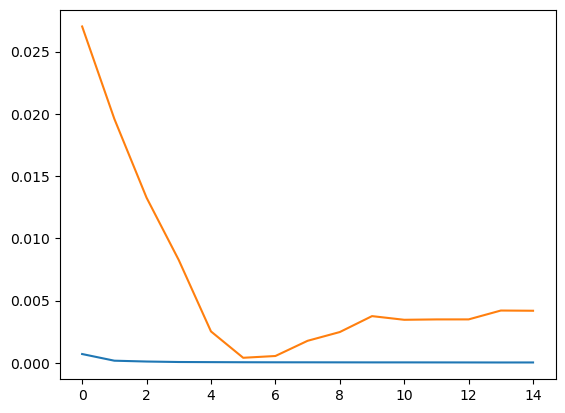

In [12]:
loss_per_epoch = model.history.history['loss']
val_loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.plot(range(len(val_loss_per_epoch)), val_loss_per_epoch)

In [13]:
last_train_batch = scaled_train[-n_input:] 
# take the last n_input month of values, to make 
# predictions on the 1st test set

In [14]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [15]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 122ms/step


array([[0.06120967]], dtype=float32)

In [16]:
validation_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(validation_data)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    validation_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [17]:
validation_predictions
# NOTE: these predictions are in the range 0-1
# we need to convert it back 

[array([0.06120967], dtype=float32),
 array([0.06905971], dtype=float32),
 array([0.07817407], dtype=float32),
 array([0.08856601], dtype=float32),
 array([0.10030887], dtype=float32),
 array([0.11353701], dtype=float32),
 array([0.12845288], dtype=float32),
 array([0.14531085], dtype=float32),
 array([0.16441062], dtype=float32),
 array([0.18605125], dtype=float32),
 array([0.21052161], dtype=float32),
 array([0.23815611], dtype=float32),
 array([0.2693343], dtype=float32),
 array([0.3044833], dtype=float32),
 array([0.34408695], dtype=float32),
 array([0.38869894], dtype=float32),
 array([0.43895686], dtype=float32),
 array([0.49559546], dtype=float32),
 array([0.5594608], dtype=float32),
 array([0.63152266], dtype=float32),
 array([0.71288556], dtype=float32),
 array([0.8047969], dtype=float32),
 array([0.90864676], dtype=float32),
 array([1.025959], dtype=float32),
 array([1.1583664], dtype=float32),
 array([1.3075638], dtype=float32),
 array([1.4752322], dtype=float32),
 array([1.

In [18]:
true_predictions = scaler.inverse_transform(validation_predictions)

In [19]:
validation_data['Predictions'] = true_predictions

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_43721/2311742674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Predictions'] = true_predictions


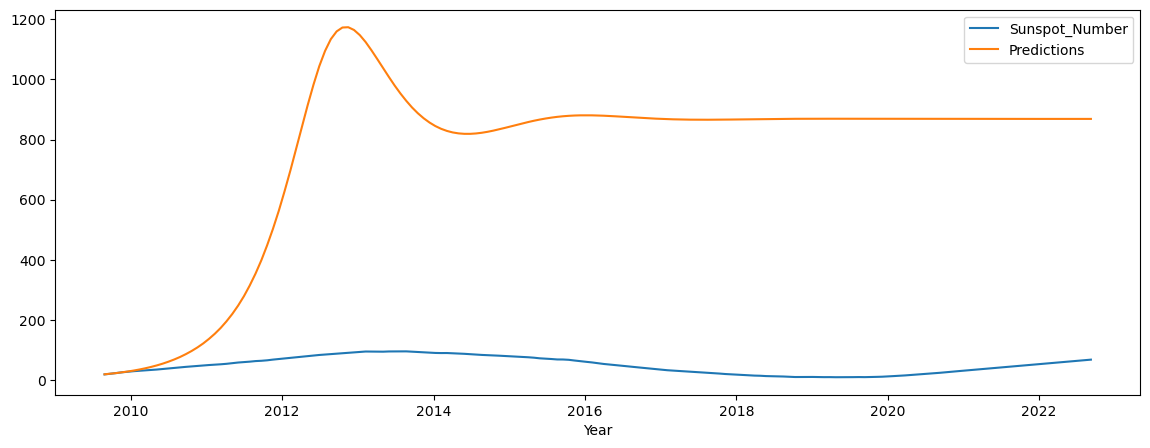

In [20]:
validation_data.plot(figsize=(14,5));

### Comment on plot:
Initially started using an RNN with a ReLu activation function, which produced some form of results, but they didn't fit well to the data.

I have attempted to use a Sigmoid function instead, which again seems to produce some form of results, but it predicts the sunspot number to be much higher than it was, and doesn't seem to come back down to a minimum of zero. One positive note is th